# Trying to determine Customer Satisfaction based on numeric variables

**_By Isaiah Torain_**

## Summary/Introduction

Modern day businesses now rely on data to help their business. They need data help them market, data to help them run their business more efficiently, and data to help improve their products. The last topic is where I am going to focus. How to improve a product or service using data? One way is to gather customer feedback to determine if they are satisfied with your product/service and which factors best determine whether a customer is satisfied. That way you can determine which areas of the product and service to improve upon. That is the heart of the data set I am working with. Given certain factors, can I determine if a customer is satisfied with a service? A competition on Kaggle provides a dataset to try and determine if a customer is satisfied with a product. The data is presented in a csv format where there are 371 numerical variables representing different customer factors (these actual field variable names are hidden due to legal reasons). The target is simply category: 0 for customer sastification and 1 for a customer being unsatisfied. One of the difficulties with this data is that the data provided is skewed. About 96% of the samples are satisfied customers and the rest are unsatisfied instead of being a 50/50 split. I determined an optimal model for predicting customer satisfaction by comparing LDA, QDA, logistic, and Non-logistic regression. Feature engineering was also used to select only the variables that mattered most in predicting customer satisfaction. The result is that

## Methods

Let me start by visualizing the initial data to see whats going on.

In [108]:
import pandas
import numpy as np
import time
import matplotlib.pyplot as plt
import mlutils as ml
import neuralnetworks as nn
import qdalda as ql
import itertools
import imp

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.feature_selection import SelectFromModel

imp.reload(nn)
imp.reload(ml)
%matplotlib inline

def trainLDA(X, T, parameters):
    lda = ql.LDA()
    lda.train(X,T)
    return lda

def evaluateLDA(model, X, T):
    pclass, probabilities, discriminants = model.use(X)
    return np.sum(pclass.ravel()==T.ravel()) / float(len(T)) * 100

def trainQDA(X, T, parameters):
    qda = ql.QDA()
    qda.train(X, T)
    return qda

def evaluateQDA(model, X, T):
    pclass, probabilities, discriminants = model.use(X)
    return np.sum(pclass.ravel()==T.ravel()) / float(len(T)) * 100

def trainNN(X, T, parameters):
    classes = np.unique(T)
    if parameters == 0 or parameters == [0] or parameters is None or parameters == [None]:
        nnet = nn.NeuralNetworkClassifier(X.shape[1], None, classes.shape[0])
        nnet.train(X, T)
    elif type(parameters) is int:
        nnet = nn.NeuralNetworkClassifier(X.shape[1], parameters, classes.shape[0])
        nnet.train(X, T)
    elif type(parameters) is list and len(parameters) == 1:
        nnet = nn.NeuralNetworkClassifier(X.shape[1], parameters[0], classes.shape[0])
        nnet.train(X, T)
    else:
        nnet = nn.NeuralNetworkClassifier(X.shape[1], parameters[0], classes.shape[0])
        nnet.train(X, T, nIterations = parameters[1])
    return nnet

def evaluateNN(model, X, T):
    results = model.use(X)
    return np.sum(results.ravel()==T.ravel()) / float(len(T)) * 100

def showResults(pclass, Targets, whichAlgo, probabilities=None):
    Tclasses = np.array([0,1])
    classes,counts = np.unique(pclass,return_counts=True)
    print('classes',classes)
    print('counts',counts)
    ml.confusionMatrix(Targets,pclass,Tclasses)
    print("ROC AUC: ", roc_auc_score(Targets, pclass))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(Targets, pclass)
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(Targets.ravel(), pclass.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.figure()
    plt.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for %s' % whichAlgo)
    plt.legend(loc="lower right")
    plt.show()

def printResults(label,results):
    print('{:4s} {:>20s}{:>8s}{:>8s}{:>8s}'.format('Algo','Parameters','TrnAcc','ValAcc','TesAcc'))
    print('-------------------------------------------------')
    for row in results:
        # 20 is expected maximum number of characters in printed parameter value list
        print('{:>4s} {:>20s} {:7.2f} {:7.2f} {:7.2f}'.format(label,str(row[0]),*row[1:]))

In [109]:
data = pandas.read_csv("train.csv")
data.head()
targets = pandas.DataFrame(data.TARGET.value_counts())
targets['Percentage'] = 100*targets['TARGET']/data.shape[0]
targets

,TARGET,Percentage
0,73012,96.043147
1,3008,3.956853


It's clear that the unsatisfied customer are the outliers in this case but which factors are the best predictor of these outliers is the question. There are many ways to do classification, one of the first is removing categorical variables.

I want to make sure the data is cleaned before I proceed with analyzing it. To do this I will find out which variables are duplicates and which rows are duplicates.


In [110]:
def removeDuplicates(data):
    data.drop_duplicates()
    remove = []
    columns = data.columns
    for i in range(len(columns) - 1):
        values = data[columns[i]].values
        for j in range(i+1,len(columns)):
            if np.array_equal(values, data[columns[j]].values):
                remove.append(columns[j])
    data.drop(remove, axis=1, inplace=True)

I also need to remove columns with the same constant values

In [111]:
def removeConstantColumns(data):
    remove = []
    for col in data.columns:
        if data[col].std() == 0:
            remove.append(col)
    data.drop(remove, axis=1, inplace=True)

In [112]:
removeDuplicates(data)
removeConstantColumns(data)
data.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


According to this link () column var3 is supposed to be the nationality of the customer. -999999 represents the nationality or country of origin not being known. Thus it is a categorical variable. I will take -9999999 as being 2. The ID column also needs to be dropped.

In [113]:
data.var3.replace(-999999, 2)
data.drop(["ID"], axis =1)

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,2,23,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,2,34,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,2,23,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,2,37,0.0,195.00,195.00,0.00,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,2,39,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
5,2,23,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87975.750000,0
6,2,27,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94956.660000,0
7,2,26,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,251638.950000,0
8,2,45,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101962.020000,0
9,2,25,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,356463.060000,0


Now I will try out my various models to see how they do.

In [114]:
#test_data = pandas.read_csv("test.csv")
#removeDuplicates(test_data)
#removeConstantColumns(test_data)
#test_data.var3.replace(-999999, 2)
#test_data.drop(["ID"], axis = 1)
#test_data = test_data.as_matrix()
train_data = data.as_matrix()
Targets = train_data[:,-1]
Targets = Targets.reshape((-1,1))
train_data = np.delete(train_data, -1, 1)
print (train_data.shape)
#print (test_data.shape)

(76020, 307)


classes [ 0.  1.]
counts [51371 24649]
       0    1
    ------------
 0 | 69.2 30.8   (73012 / 73012)
 1 | 27.3 72.7   (3008 / 3008)
ROC AUC:  0.70970655618


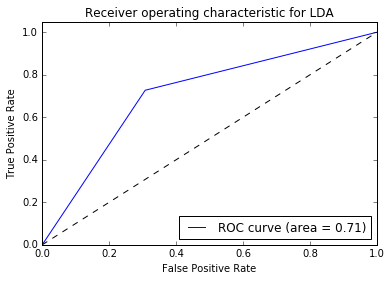

In [115]:
lda = ql.LDA()
lda.train(train_data, Targets)
pclass, probabilities, discriminants = lda.use(train_data)
showResults(pclass,Targets, "LDA")

classes [ 0.  1.]
counts [71233  4787]
       0    1
    ------------
 0 | 94.1  5.9   (73012 / 73012)
 1 | 85.1 14.9   (3008 / 3008)
ROC AUC:  0.544753791566


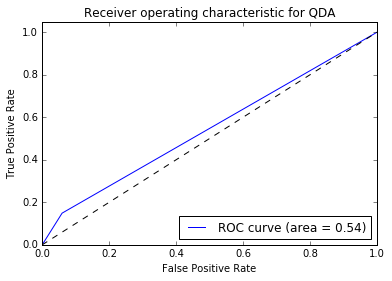

In [116]:
qda = ql.QDA()
qda.train(train_data, Targets)
pc, prob, d = qda.use(train_data)
showResults(pc, Targets, "QDA")

96.0326229939
classes [ 0.  1.]
counts [75982    38]
       0    1
    ------------
 0 |100.0  0.0   (73012 / 73012)
 1 | 99.5  0.5   (3008 / 3008)
ROC AUC:  0.502335842709


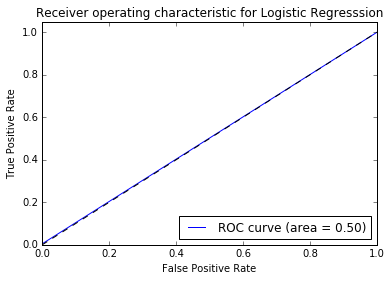

In [98]:
nnet = nn.NeuralNetworkClassifier(train_data.shape[1], None, Tclasses.shape[0])
nnet.train(train_data, Targets)
results = nnet.use(train_data)
print (np.sum(results.ravel()==Targets.ravel()) / float(len(Targets)) * 100)
showResults(results, Targets, "Logistic Regresssion")

[307, 10, 30]
96.1325966851
classes [ 0.  1.]
counts [75900   120]
       0    1
    ------------
 0 |100.0  0.0   (73012 / 73012)
 1 | 96.9  3.1   (3008 / 3008)
ROC AUC:  0.515446947077


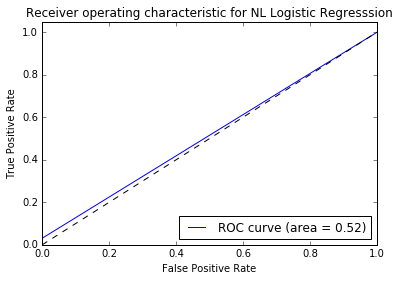

In [99]:
nnet = nn.NeuralNetworkClassifier(train_data.shape[1], [10, 30], Tclasses.shape[0])
nnet.train(train_data, Targets)
results = nnet.use(train_data)
print (np.sum(results.ravel()==Targets.ravel()) / float(len(Targets)) * 100)
showResults(results, Targets, "NL Logistic Regresssion")

In [52]:
resultsLDA = ml.trainValidateTestKFoldsClassification(trainLDA, evaluateLDA, train_data, Targets, [None], nFolds=6, shuffle=True, verbose=False)
printResults('LDA: ', resultsLDA)

Algo           Parameters  TrnAcc  ValAcc  TesAcc
-------------------------------------------------
LDA:                  None   69.66   57.95   69.90
LDA:                  None   69.49   57.80   69.99
LDA:                  None   69.52   57.80   69.63
LDA:                  None   69.36   57.72   68.92
LDA:                  None   69.54   57.82   69.29
LDA:                  None   69.47   57.83   68.33


In [81]:
resultsQDA = ml.trainValidateTestKFoldsClassification(trainQDA, evaluateQDA, train_data, Targets, [None], nFolds=6, shuffle=True, verbose=False)
printResults('QDA: ', resultsQDA)

Algo           Parameters  TrnAcc  ValAcc  TesAcc
-------------------------------------------------
QDA:                  None   86.76   71.65   80.61
QDA:                  None   85.11   70.87   81.48
QDA:                  None   84.25   70.68   83.05
QDA:                  None   84.24   70.05   85.14
QDA:                  None   83.59   69.35   87.22
QDA:                  None   83.94   69.20   89.95


In [82]:
#parameters for neural net is [[0], 10] where the first input is the number of hidden units and the second is iterations
resultsNN = ml.trainValidateTestKFoldsClassification(trainNN, evaluateNN, train_data, Targets, [None], nFolds=6, shuffle=True, verbose=False)
printResults('NN: ', resultsNN)

Algo           Parameters  TrnAcc  ValAcc  TesAcc
-------------------------------------------------
QDA:                  None   88.76   74.04   80.24
QDA:                  None   88.07   73.54   83.03
QDA:                  None   87.39   72.98   85.85
QDA:                  None   86.79   72.46   88.53
QDA:                  None   86.21   71.96   91.44
QDA:                  None   85.67   71.45   94.61


In [85]:
resultsNN = ml.trainValidateTestKFoldsClassification(trainNN, evaluateNN, train_data, Targets, [[[5], 10]], nFolds=10, shuffle=True, verbose=False)
printResults('NN: ', resultsNN)

[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
[307, 5]
Algo           Parameters  TrnAcc  ValAcc  TesAcc
-------------------------------------------------


In [87]:
resultsNN = ml.trainValidateTestKFoldsClassification(trainNN, evaluateNN, train_data, Targets, [[[50, 50], 5]], nFolds=10, shuffle=True, verbose=False)
printResults('NN: ', resultsNN)

[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
[307, 2]
Algo           Parameters  TrnAcc  ValAcc  TesAcc
-------------------------------------------------


Seems as though the neural network could do better but that could also be the result of the data being skewed and it doing really well on the targets of 0. Next I will remove features to try to get a better model.

C:\Users\Zay\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


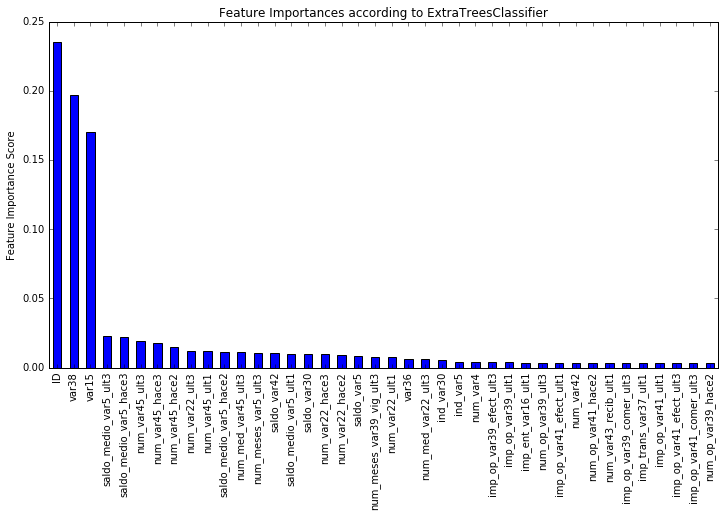

In [118]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(random_state=1729)
data = data.drop(["TARGET"], axis =1)
selector = clf.fit(data, Targets)

# plot most important features
feat_imp = pandas.Series(clf.feature_importances_, index = data.columns.values).sort_values(ascending=False)
feat_imp[:40].plot(kind='bar', title='Feature Importances according to ExtraTreesClassifier', figsize=(12, 8))
plt.ylabel('Feature Importance Score')
plt.subplots_adjust(bottom=0.3)
plt.savefig('1.png')
plt.show()

# clf.feature_importances_ 
fs = SelectFromModel(selector, prefit=True)

newTrain = fs.transform(data)

In [119]:
print (newTrain.shape)

(76020, 31)


classes [ 0.  1.]
counts [50711 25309]
       0    1
    ------------
 0 | 68.2 31.8   (73012 / 73012)
 1 | 29.5 70.5   (3008 / 3008)
ROC AUC:  0.693590954445


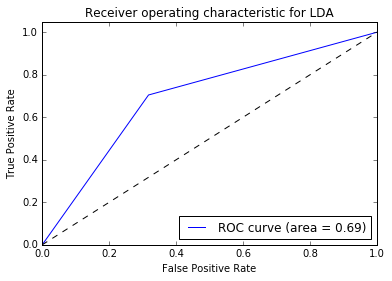

In [120]:
lda = ql.LDA()
lda.train(newTrain, Targets)
pclass, probabilities, discriminants = lda.use(newTrain)
showResults(pclass,Targets, "LDA")

classes [ 1.]
counts [76020]
       0    1
    ------------
 0 |  0  100.0   (73012 / 73012)
 1 |  0  100.0   (3008 / 3008)
ROC AUC:  0.5


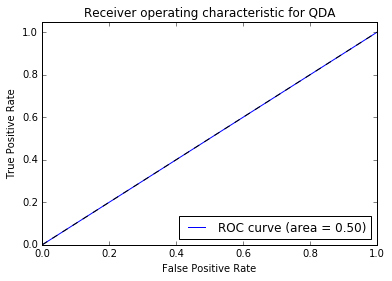

In [121]:
qda = ql.QDA()
qda.train(newTrain, Targets)
pclass, probabilities, discriminants = qda.use(newTrain)
showResults(pclass,Targets, "QDA")

96.0326229939
classes [ 0.  1.]
counts [76010    10]
       0    1
    ------------
 0 |100.0  0.0   (73012 / 73012)
 1 |100.0  0.0   (3008 / 3008)
ROC AUC:  0.5001045897


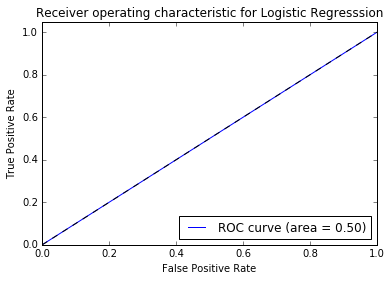

In [84]:
nnet = nn.NeuralNetworkClassifier(newTrain.shape[1], None, Tclasses.shape[0])
nnet.train(newTrain, Targets)
results = nnet.use(newTrain)
print (np.sum(results.ravel()==Targets.ravel()) / float(len(Targets)) * 100)
showResults(results, Targets, "Logistic Regresssion")

[31, 5, 10, 15, 20, 15, 10, 5]
96.0444619837
classes [ 0.  1.]
counts [76015     5]
       0    1
    ------------
 0 |100.0  0.0   (73012 / 73012)
 1 | 99.9  0.1   (3008 / 3008)
ROC AUC:  0.500484973834


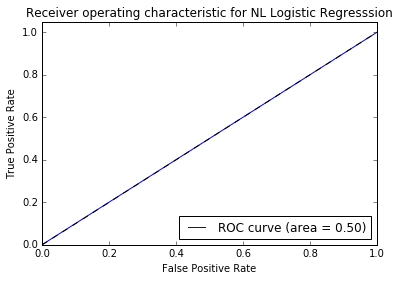

In [125]:
nnet = nn.NeuralNetworkClassifier(newTrain.shape[1], [5, 10, 15, 20, 15, 10, 5], Tclasses.shape[0])
nnet.train(newTrain, Targets, nIterations=100)
results = nnet.use(newTrain)
print (np.sum(results.ravel()==Targets.ravel()) / float(len(Targets)) * 100)
showResults(results, Targets, "NL Logistic Regresssion")

In [126]:
import xgboost
boosted = xgboost.XGBClassifier(n_estimators=110, nthread=-1, max_depth=4, seed=1729)
boosted.fit(newTrain, Targets, eval_metric="auc", verbose=False)
print ("AUC: ", roc_auc_score(Targets, boosted.predict_proba(newTrain), average='macro'))

ImportError: No module named 'xgboost'

## Results

It seems I could achieve no better than an AUC of about .70 in all tests. That is not bad however some of the Kaggle competitors were able to achieve about .84 using a tool called xgboost (Extreme Gradient Boosting).

## Conclusion

In conclusion, using several different models it seems the best way to predict an unbalanced dataset with a lot of attributes is using Linear discriminant analysis. One difficulty I ran into was calculating the ROC but once I found out about the sklearn toolkit it was easy. 
